# Phase 1 - Project 1
## **Overview**
Microsoft is planning to start making movies and we are tasked to give the new department movie recommendations to help them start. We will look at movie genres, popularity, production budget, domestic gross, foreign gross and director's movie rankings from various different websites to back our claims. The top movies are ranked and their genres are totaled to see if we can correlate genres and popularity. **The results shows a distinct popularity to action, adventure, sci-fi and fantasy as well as a poor performance to documentry, horror, thriller and comedy.** These genres were both profitable and successful.  <br>
**Production budget have a small influence in world gross box office with a 1:2 ratio of dollar returned for every dollar spent.** A created variable ended being a bad metric to determine success. <br>
Lastly, with the top movies from the previous data, **we can determine the best director to produce the movie**. IMDB provide the individual performance of the directors to see if they already have high performing movies from The Movie DB. Picking from the top rated directors will give another advangate for the movie success.

## **Business Understanding**
The main aspect we care about is whether or not a movie is profitable. 
Biggest indicator are popular movies so we will be looking at past popular movies and comparing the budget they spent and their gross box office
This may give insight to what type of movie makes them popular and inturn profitable. We first need to show the correlation between popular movie and profit as we will see later that a 'profitable' movie are always the most popular if we consider the scale of the movie. Investors would be more willing to invest if there is a certain guarentee on the movie's success. 

## **Data Understanding**
Their are several dataset are will be pulled together to support the claim we will be making.  <br>
[The Movie DB](https://www.themoviedb.org/) has data their popularity as well as a useful column, genre ID. All other attributes such as release data are not being used in this analysis. There was a helpful [forum](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee) that explains the genre id to their respective genres. <br>
[The Numbers](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee) will be providing the profit and budget of the movies which can be sorted and filtered out to see how these movies perform, whether they are popular or highly rated. <br>
[IMDB](https://www.imdb.com/) has an extensive database that contains movies, rating and people who worked on the movie. For this project, we will be specifically seeing the impact of movies based on their directors. <br>

This project aims to present Microsoft with recommendations for the production of a movie that would lead to the most profitable movie.
We will look at movie genre, popularity, production budget, domestic gross, foreign gross and director ranking. 
The top movies are ranked and their genre are totaled to see if we can see a trend. The results shows a district popularity to action, adventure, sci-fi and fantasy 
as well as a poor performance to documentry, horror, thriller and comedy.  <br>
We created another measurement, ratios for production budget and their domestic gross and foreign gross. Strictly speaking, a ratio of over 1 is a net profit for the movie so I tried find the most optimal budget to garentee the highest likely profit, ie the greatest ratio. Lastly, with the top movies from the previous data, we can determine the best director to produce the movie. IMDB provide the individual performance of the directors to see if they already have high performing movies from The Movie DB. Picking from the top rated directors will give another advangate for the movie success. 

### Data Imports

In [1]:
import csv    #for the cvs and txv files
import sqlite3 as sql   #for the db file
import pandas as pd    #Help visualize the data
import resources.visualization as dv

In [2]:
df_1 = pd.read_csv("data/tmdb.movies.csv")   
df_2 = pd.read_csv("data/tn.movie_budgets.csv")
df_3 = pd.read_csv('data/rt.reviews.tsv',delimiter = '\t', encoding = 'cp437' )    #- Decided against using Rotten Tomatoes datasets
df_4 = pd.read_csv('data/rt.movie_info.tsv',delimiter = '\t')
df_5 = pd.read_csv('data/bom.movie_gross.csv',delimiter = '\t')
conn = sql.connect('data/im.db/im.db')

**The Movie DB** <br>
Useful keys: Popularity, vote count, vote average <br>
Most movie have a genre and a rating from The Movie DB that can be sorted and organized.
Language and release data will not be used for this project.

In [3]:
df_1.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


**The Number** <br>
Useful Keys: Production Budget, Domestic Budget, Worldwide Budget. <br>
The data set have valuable information to show stakeholders how much profit a movie can potential have. 

In [4]:
df_2.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


**Rotten Tomatoes** <br>
Useful keys: Freshness, critic, top critic and publisher - May not be used <br>
Data has too many missing and NaN values to be used at its current state. <br>
Will Opt to not use this dataset. Too many NaN and Null values to be practical to use. 

In [5]:
print(df_3.isna().sum())  
print(df_4.isna().sum()) 

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64
id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64


**IMDB** <br>
We will be focusing mainly on the directors connection to the movies

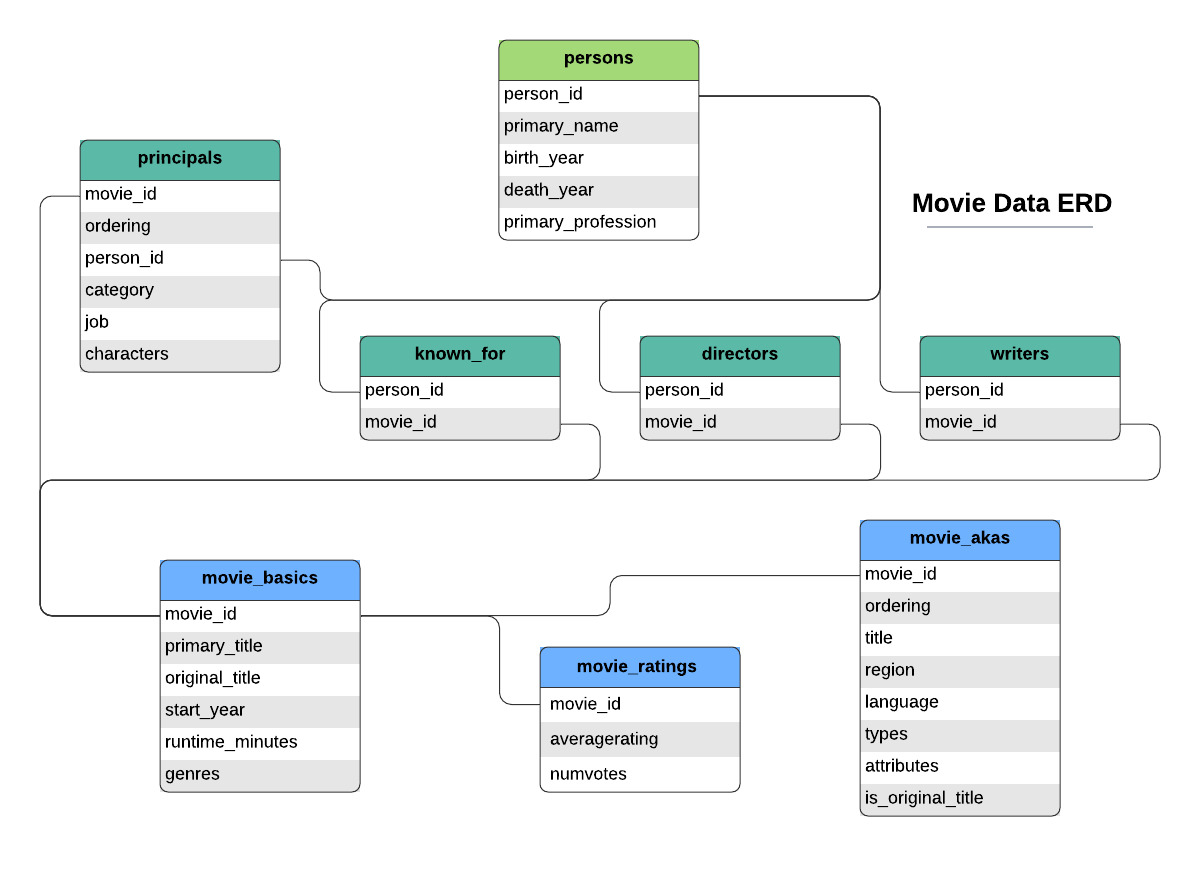

Conclusion: Both The Numbers and Box Office Mojo have similar dataset. Will The The Numbers for consistancy purposes
            Rotten Tomatoes and IMDB have data with NaN values which will not be usable for those given columns
             The Rotten Tomatoes dataset were missing values and were not used at the time.


In [6]:
### Sort the directors by average rating and number of number
pd.read_sql("""SELECT  persons.primary_name AS 'Director Name' , AVG(averagerating) AS 'Average Rating', COUNT(movie_id) AS 'Number of Movies'
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
JOIN directors
    USING (movie_id)
JOIN persons
    USING (person_id)

GROUP BY persons.primary_name
ORDER BY AVG(averagerating) DESC
LIMIT 5
""", conn)
### We only care about high rated movies and directors with at least above average of movies ###

,Director Name,Average Rating,Number of Movies
0,Tristan David Luciotti,10.0,1
1,Stephen Peek,10.0,1
2,Michiel Brongers,10.0,1
3,Masahiro Hayakawa,10.0,1
4,Loreto Di Cesare,10.0,2


## Data Preperation

In [7]:
import numpy as np
import resources.data_cleaning as dp
%matplotlib inline

### Data Cleaning
The data from The Movie and The Numbers need to be formatted so that we can use them. <br>
We will primaryly working with the top most popular movies, and best performing movies

#### The Moive DB
Dropping Unnamed column and remove duplicates are removed and we formatted the genre list so that it is readable.

In [8]:
df_1['Unnamed: 0']                                  #No use, index column
df_1.drop("Unnamed: 0", axis = 1, inplace= True)    #Remove the column
df_1.drop_duplicates(inplace = True)                #Remove dups

#Format the genre id to be treated as a list, currently a string with extra characters ([],',')
df_1['genre_ids'] = dp.clean_genre(df_1)

In [9]:
#Sort by popularity to see whats type of movies are the best and the worst
df_1.sort_values('popularity', inplace = True,ascending= False)    #Only care about the most popular movies
df1_top_movies = df_1[0:100]    #Top 100 movies 
df1_worst_movie = df_1[-100:]    #Worst 100 movies

df1_top_list = list(df1_top_movies['title'])    #Top 100 movies title from the first dataset
df1_top_genre = dp.count_genre(df1_top_movies, 'genre_ids')    #Top genres from the most popular movies
df1_worst_genre = dp.count_genre(df1_worst_movie, 'genre_ids')    #Top genres from teh worst movies

#### The Numbers 
Nothing to removed. Budget and Gross Income are changed for statistical purposes. A ratio column is created to see how much profit the movie made. <br>

In [10]:
# Clean up the budget from string to int
df_2['production_budget'] = dp.clean_df(df_2['production_budget'])
df_2['domestic_gross'] = dp.clean_df(df_2['domestic_gross'])
df_2['worldwide_gross'] = dp.clean_df(df_2['worldwide_gross'])

### The Number - Ratios
Ratio = Production Budget / Domestic Gross (Production Budget / Foriegn Gross) <br>
Used to determine how profitable a movie by the scale of the movie's budget. This will make it easier when a movie failed, or have a net negative in box office. 

In [11]:
###   Make the ratio for both the profit
df_2['prod_dom_ratio'] = df_2['domestic_gross'] / df_2['production_budget']    #Ratio on the more proftitable movie - Domestic
df_2['prod_world_ratio'] = df_2['worldwide_gross'] / df_2['production_budget']    #Ratio on the more proftitable movie - worldwide
###    Production vs Domestic Ratio    ###
df2_most_prof = df_2['movie'].loc[df_2['prod_dom_ratio'] > 1]
df2_most_prof_2 = df_2['movie'].loc[df_2['prod_dom_ratio'] > 2]
df2_most_prof_3 = df_2['movie'].loc[df_2['prod_dom_ratio'] > 3] 
###    Production vs WorldWide Ratio    ###
df2_most_prof_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 1]  
df2_most_prof_2_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 2]  
df2_most_prof_3_world = df_2['movie'].loc[df_2['prod_world_ratio'] > 3]  

### The Movie DB and The Number
Combine the two dataset to see the correlation between the genre and the most profitable movies

In [12]:
#    Over_# is the list of genre based on the movies with the respective ratios
#    If the movie is also in the most profitable list and the most popular list,
#    they count the genre for that ratio
###    Genres from movie's Domestic Gross Ratio over 1, 2, and 3    ####
over_1 = dp.count_genre(df_1.loc[df_1['title'].isin(dp.list_of_movies(df2_most_prof, df1_top_list ))]
                        ,'genre_ids')    
over_2 = dp.count_genre(df_1.loc[df_1['title'].isin(dp.list_of_movies(df2_most_prof_2, df1_top_list))]
                        ,'genre_ids')
over_3 = dp.count_genre(df_1.loc[df_1['title'].isin(dp.list_of_movies(df2_most_prof_3, df1_top_list))]
                        ,'genre_ids')
###    Genres from movie's Foreign Gross Ratio over 1, 2, and 3    ####
over_1_w = dp.count_genre(df_1.loc[df_1['title'].isin(dp.list_of_movies(df2_most_prof_world, df1_top_list))]
                         ,'genre_ids')
over_2_w = dp.count_genre(df_1.loc[df_1['title'].isin(dp.list_of_movies(df2_most_prof_2_world, df1_top_list))]
                         ,'genre_ids')
over_3_w = dp.count_genre(df_1.loc[df_1['title'].isin(dp.list_of_movies(df2_most_prof_3_world, df1_top_list))]
                         ,'genre_ids')
###    All genres list from all movies
all_genre = dp.count_genre(df_1
                          ,'genre_ids')

In [13]:
#Determine a reasonable range of budget that gives the most benifical ratio possible
budget_max = (dp.find_min_max(df_2['production_budget']))[1]
ratio_max = (dp.find_min_max(df_2['prod_world_ratio']))[1]

Max Outlier:  69500000.0
Max Outlier:  6.607385548232989


In [14]:
# Dataset with all outliers removed
outlier_removed = df_2.loc[(df_2['prod_world_ratio'] <= ratio_max) & (df_2['production_budget'] <= budget_max)]

### IMDB
Database that has alot of information so will be only focusing on director

In [15]:
#Group the table with the directors with the number of movies they have made
dv.read_sql(conn)
list_of_directors = dv.top_directors(conn)    #Obtain the list of directors with the best average reviews on their movies
Recommended_dir = dv.top_dir_and_movies(conn)    #From the list of directors, filter out the directors with movies in the top 100 movies,

## Data Analysis

In [16]:
import matplotlib.pyplot as plt

### Best and Worst Movie Genre
The most popular movies genres were action, adventure, sci-fi and fantasy. <br>
The worst movie genre were documentary, comedy and movie with no genre listed (too short, too vague) <br>
Drama was seen in both the worst and the best genre which may be the result of the genre being combined with others.
The most used genre aren't the most popular and should be advise to use one of the best performing genre instead. 

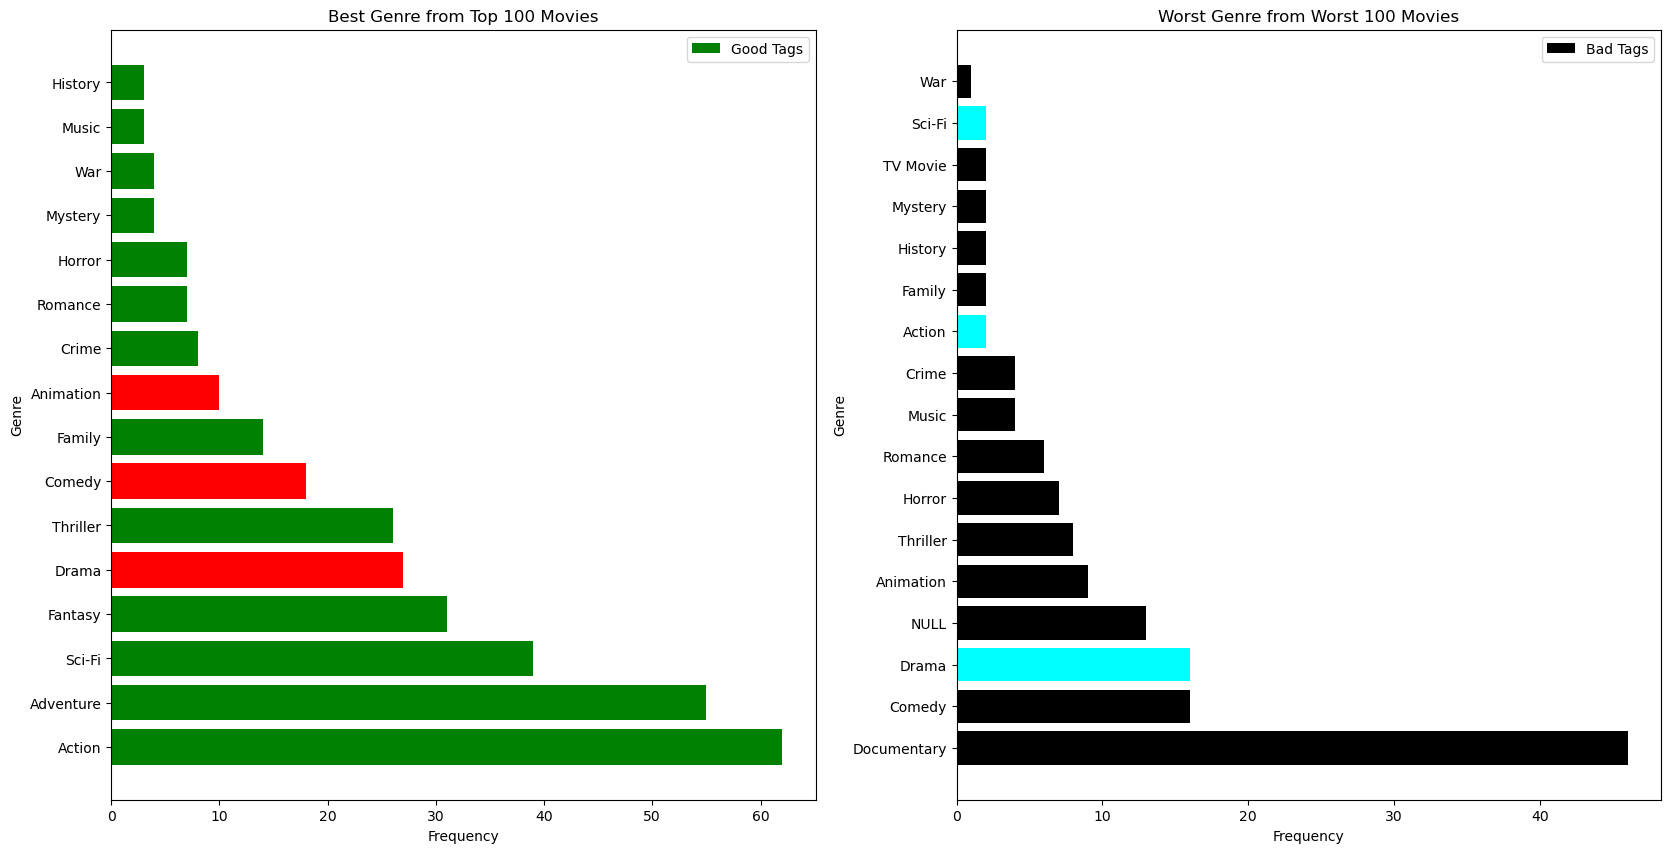

In [17]:
dv.worst_and_best(df1_top_genre, df1_worst_genre)

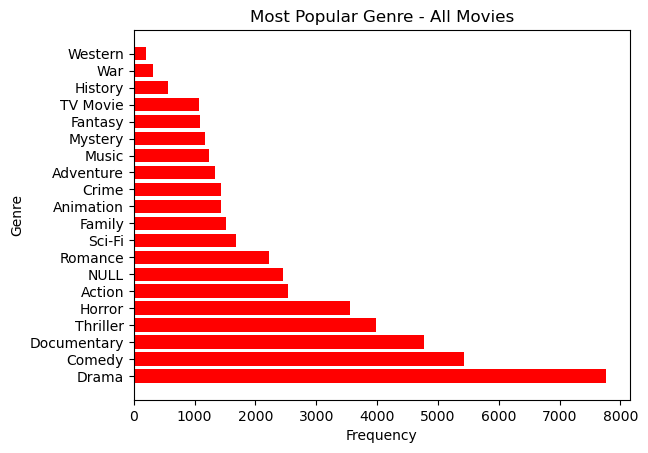

In [18]:
dv.top_genre(all_genre)

### Most Profitable Genre 
Domestically, there was a pretty broad range of genre that resulted in a higher ratio. 
Internationally, there was a clear difference and the data lined up almost one to one, where the most popular genres were also the most profitable. Other genres may perform better domestical but fall behind the top genre internationally.

#### Domestic Gross


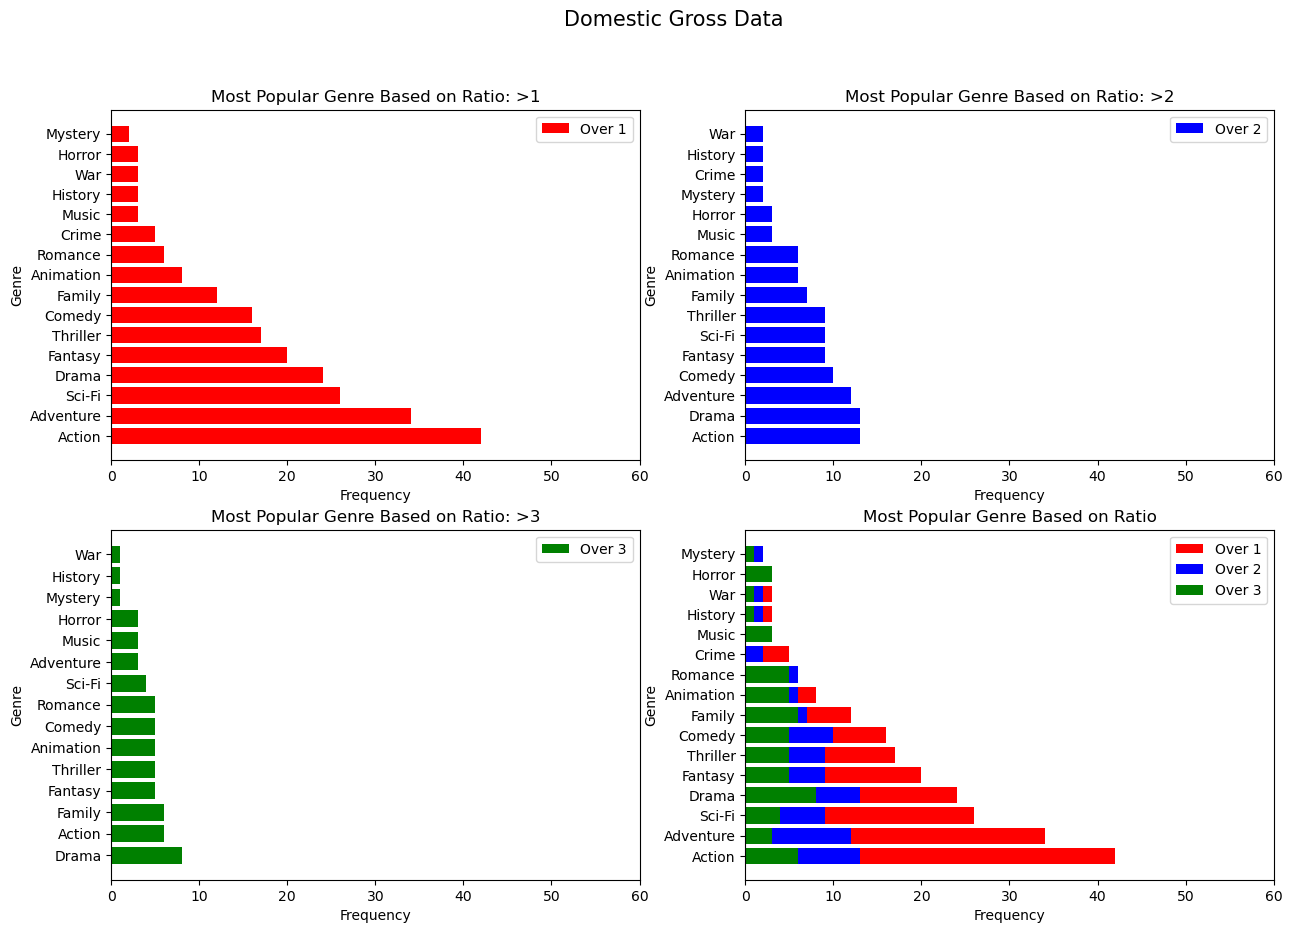

In [19]:
dv.genre_comparison('Domestic Gross Data' ,over_1, over_2, over_3)

#### Foreign Gross

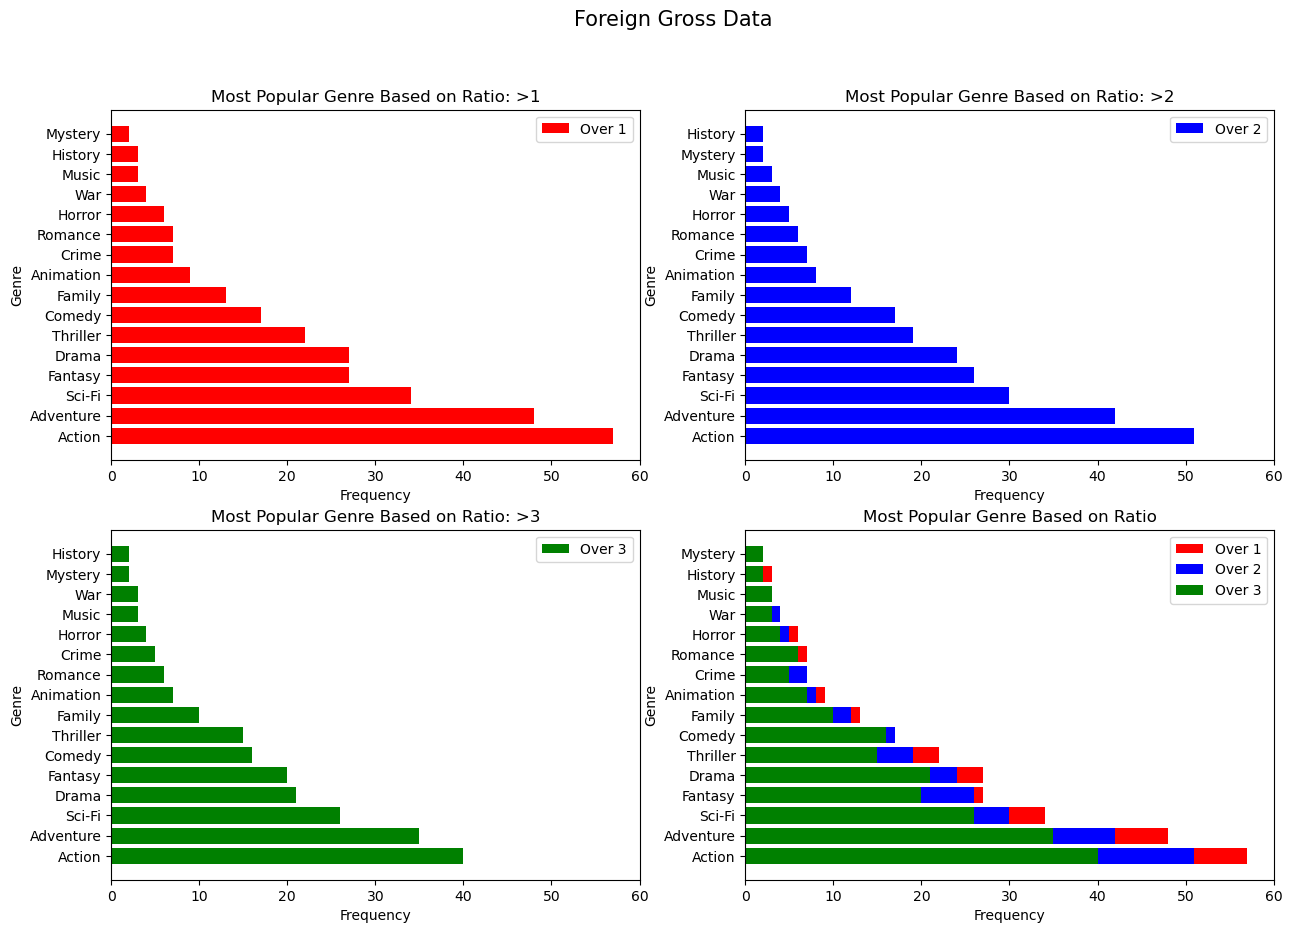

In [20]:
dv.genre_comparison('Foreign Gross Data',over_1_w, over_2_w, over_3_w)

### Top Movies' Ratio and World Gross
There was fractional relationship between production budget and the scale of the profit. This is heavily screwed since the median and mean are only 17,000,000 and 31,000,000 respectively. <br>
There was a positive relatioship between money spent and world gross box office. 
Formula: y = 2.03(x)-2,521,401 - For every million invested, there is an expected 2 million gain for it, <br>
ie **1:2 gain.**

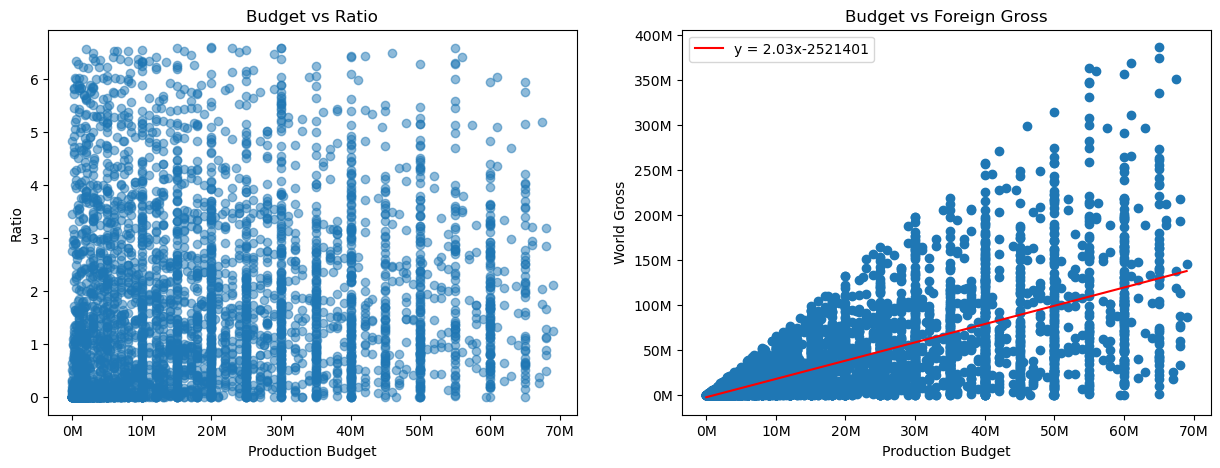

In [21]:
dv.graph_budgets(outlier_removed)

### **The Best Movie Directors and piece of work**
Pulling from all the best rated movies and their directors that made it to the top 100 movies from the previous dataset. This gets a list with the most qualify directors to hire for the production of the movie. 

In [22]:
print(set(Recommended_dir['Director Name']))
Recommended_dir

{'James Gunn', 'Byron Howard', 'Taika Waititi', 'Anthony Russo', 'Chris Williams', 'Bradley Cooper', 'Dean DeBlois', 'Peter Ramsey'}


,Movie Title,Director Name,Number of Movies,Average Movie Ratings
0,Spider-Man: Into the Spider-Verse,Peter Ramsey,6,8.5
1,Avengers: Infinity War,Anthony Russo,24,8.5
2,How to Train Your Dragon,Dean DeBlois,12,8.1
3,Guardians of the Galaxy,James Gunn,11,8.1
4,Zootopia,Byron Howard,24,8.0
5,Thor: Ragnarok,Taika Waititi,9,7.9
6,A Star Is Born,Bradley Cooper,9,7.8
7,Captain America: Civil War,Anthony Russo,12,7.8
8,Big Hero 6,Chris Williams,12,7.8
9,Guardians of the Galaxy Vol. 2,James Gunn,13,7.7


## Conclusion
In order for the highest possiblity of making a successful movie, it is recommended for the movie to have these attributes. <br>
**The movie should have one or a combination of action, adventure, sci-fi or fantasy with a limited drama.** Documentaries should be avoided and keep thriller and horror to a minimum <br>
**The movie's budget should be limited to under $60,000,000 though a higher budget slightly increase gross box office.** A higher budget, however, will not directly result in a higher ratio but rather a constistent postive net profit during box office. <br>
**One of the listed directors should be managing if possible.** There were an list of new directors with high average rating but was filtered out due to lack of movies produced. 

Although genre would be easy to adapt in a movie, budget and directors aren't as flexible. Budget are usually finite and there wasn't any conclusive evidence stating whether a low budget movie would lead to a profitable movie but rather a higher budget is more likely to get a profitable movie. 
In the future, it would be an interesting concept to see if leading actors would benifit a movie's profit and see whether a desirable actor is worth the cost to be in a movie to justify it. High demand would potential result in a higher budget. 

## Next Steps
This project primary focus on attributes before movie production such as budget, genre and directors. A movie is a multi-step process and we should look into aspects such as:
+ **Leading actors and their affect on a movie popularity or profit.** High profile actors may boost sales but might not justify the wage if over budget.
+ **Perhaps there is a combination of genre that may result in the best movie for the audience.** Many genres overlap, like action and adventure, which could be more popular than action horror. This could be analysis with the current data we have. 
+ **Seeing whether or not, new directors are performing better than old directors.** There were several movies that have been sequelized and newer directors making highly rated movies. Analysing this may give us insight on whether or not, newer talents should be producing movies instead of the experience director we recommended. 